In [1]:
import pandas as pd
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
btc_ohlcv = pd.read_csv('Bitcoin futures (USDT) 25-03-2020-10-36-00_03-05-2025-00-00-00 timeframe 1m.csv')
btc_ohlcv.set_index('timestamp', inplace=True)
btc_ohlcv.index = pd.to_datetime(btc_ohlcv.index)
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2020-03-25 10:36:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


In [3]:
btc_ohlcv = btc_ohlcv[-2*12*30*24*60:]
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2023-05-14 00:01:00,26765.3,26782.1,26765.3,26782.0,28.984
2023-05-14 00:02:00,26782.0,26782.1,26774.0,26779.1,15.530
2023-05-14 00:03:00,26779.1,26779.2,26761.0,26761.0,55.433
2023-05-14 00:04:00,26761.0,26761.1,26753.1,26753.1,93.341
2023-05-14 00:05:00,26753.1,26753.2,26739.8,26739.9,191.041
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


In [4]:
def sliding_max(arr: np.ndarray, k: int) -> np.ndarray:
    """Sliding-window maximum (window size k) for arr."""
    n = arr.size
    max_vals = np.full(n, np.nan)
    dq = deque()
    for i in range(n):
        # mantieni solo valori utili nel deque
        while dq and arr[i] >= arr[dq[-1]]:
            dq.pop()
        dq.append(i)
        # scarta indici fuori finestra
        if dq[0] <= i - k:
            dq.popleft()
        # a i>=k-1 ho il primo max valido
        if i >= k - 1:
            max_vals[i] = arr[dq[0]]
    return max_vals

def sliding_min(arr: np.ndarray, k: int) -> np.ndarray:
    """Sliding-window minimum (window size k) for arr."""
    n = arr.size
    min_vals = np.full(n, np.nan)
    dq = deque()
    for i in range(n):
        while dq and arr[i] <= arr[dq[-1]]:
            dq.pop()
        dq.append(i)
        if dq[0] <= i - k:
            dq.popleft()
        if i >= k - 1:
            min_vals[i] = arr[dq[0]]
    return min_vals

def extreme_return_histogram(
    df: pd.DataFrame,
    T: int,
    agg: int = 1,
    bin_width: float = 0.01
):
    """
    Restituisce:
      - hist_pct: percentuali per bin
      - bin_edges: array dei bordi dei bin
      - hist_pct_dict: dict {intervallo_str: percentuale}
    Parametri:
      df: DataFrame con indice datetime e colonna 'close'
      T: look-ahead window in #candele
      agg: aggregazione (1 = minuto; es. 1440 = giornata)
      bin_width: ampiezza del bin (es. 0.01 = 1%)
    """
    # 1) aggregazione
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    close = df['close']
    if agg > 1:
        close = close.resample(f'{agg}T').last().dropna()
    close_vals = close.values
    n = close_vals.size
    if n <= T:
        raise ValueError(f"T={T} troppo grande rispetto a #candele={n}")

    # 2) log-price
    log_close = np.log(close_vals)

    # 3) sliding-window sui successivi T punti
    arr_rev = log_close[::-1]
    rev_max = sliding_max(arr_rev, T)
    rev_min = sliding_min(arr_rev, T)
    valid = n - T
    max_log = rev_max[T - 1 : n - 1][::-1]
    min_log = rev_min[T - 1 : n - 1][::-1]

    # 4) rendimenti estremi
    returns_max = np.exp(max_log - log_close[:valid]) - 1
    returns_min = np.exp(min_log - log_close[:valid]) - 1

    # 5) unisco e istogramma in percentuali
    all_returns = np.concatenate([returns_min, returns_max])
    total = all_returns.size
    min_edge = np.floor(all_returns.min() / bin_width) * bin_width
    max_edge = np.ceil(all_returns.max() / bin_width) * bin_width
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    counts, bin_edges = np.histogram(all_returns, bins=bins)
    hist_pct = counts / total * 100.0

    # costruisco il dizionario {intervallo: %}
    hist_pct_dict = {}
    for i in range(len(hist_pct)):
        left = bin_edges[i] * 100
        right = bin_edges[i+1] * 100
        key = f"[{left:.2f}%, {right:.2f}%)"
        hist_pct_dict[key] = (str(round(hist_pct[i], 5)) + "%", round(hist_pct[i]*total/100, 5))  # arrotondo a 3 decimali

    # plot
    plt.figure(figsize=(10, 6))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(centers, hist_pct, width=bin_width, edgecolor='black')
    plt.xlabel('Rendimento')
    plt.ylabel('Frequenza (%)')
    plt.title(
        f"Istogramma movimenti estremi entro {T*agg} candele\n"
        f"(agg={agg}, bin={bin_width*100:.1f}%)"
    )
    plt.grid(True)
    plt.show()

    return hist_pct, bin_edges, hist_pct_dict

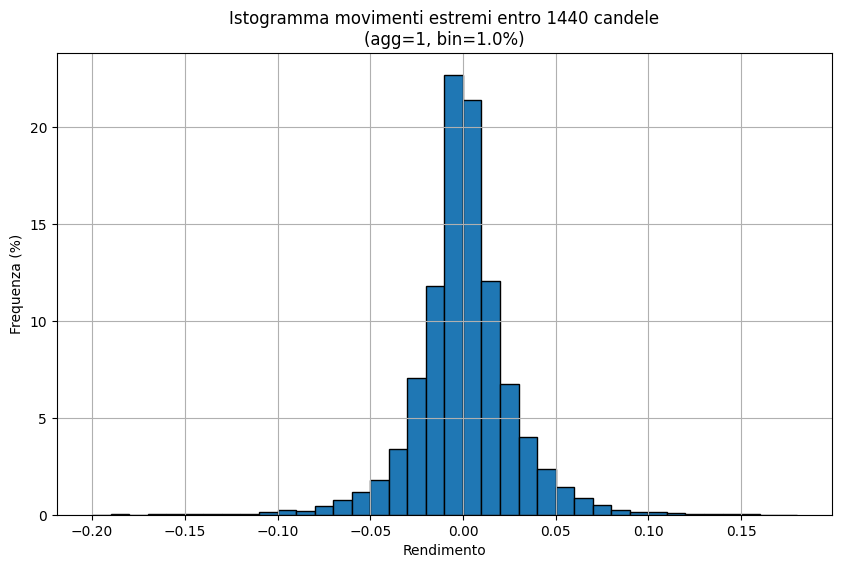

[-20.00%, -19.00%): ('0.00063%', 13.0)
[-19.00%, -18.00%): ('0.02284%', 473.0)
[-18.00%, -17.00%): ('0.0015%', 31.0)
[-17.00%, -16.00%): ('0.01811%', 375.0)
[-16.00%, -15.00%): ('0.04892%', 1013.0)
[-15.00%, -14.00%): ('0.01343%', 278.0)
[-14.00%, -13.00%): ('0.01705%', 353.0)
[-13.00%, -12.00%): ('0.02448%', 507.0)
[-12.00%, -11.00%): ('0.04453%', 922.0)
[-11.00%, -10.00%): ('0.12938%', 2679.0)
[-10.00%, -9.00%): ('0.23716%', 4911.0)
[-9.00%, -8.00%): ('0.20355%', 4215.0)
[-8.00%, -7.00%): ('0.44226%', 9158.0)
[-7.00%, -6.00%): ('0.78156%', 16184.0)
[-6.00%, -5.00%): ('1.15313%', 23878.0)
[-5.00%, -4.00%): ('1.79575%', 37185.0)
[-4.00%, -3.00%): ('3.37665%', 69921.0)
[-3.00%, -2.00%): ('7.03876%', 145753.0)
[-2.00%, -1.00%): ('11.79348%', 244210.0)
[-1.00%, 0.00%): ('22.70655%', 470189.0)
[0.00%, 1.00%): ('21.38382%', 442799.0)
[1.00%, 2.00%): ('12.04856%', 249492.0)
[2.00%, 3.00%): ('6.72191%', 139192.0)
[3.00%, 4.00%): ('4.02387%', 83323.0)
[4.00%, 5.00%): ('2.36826%', 49040.0)
[5.0

In [5]:
hist, bins, hist_map = extreme_return_histogram(
    btc_ohlcv,
    T=1440,         # guardo T minuti avanti
    agg=1,        # timeframe di agg minuti
    bin_width=0.01  # bin di una percentuale bin_width (in unità)
)

# Stampi il dizionario:
for interval, count in hist_map.items():
    print(f"{interval}: {count}")

In [6]:
hist

array([6.27800958e-04, 2.28422964e-02, 1.49706382e-03, 1.81096430e-02,
       4.89201824e-02, 1.34252820e-02, 1.70472106e-02, 2.44842374e-02,
       4.45255756e-02, 1.29375290e-01, 2.37163885e-01, 2.03552388e-01,
       4.42261629e-01, 7.81563900e-01, 1.15312548e+00, 1.79575220e+00,
       3.37665160e+00, 7.03875947e+00, 1.17934825e+01, 2.27065465e+01,
       2.13838182e+01, 1.20485628e+01, 6.72191315e+00, 4.02386609e+00,
       2.36825838e+00, 1.44746755e+00, 8.52843455e-01, 5.11319734e-01,
       2.62131046e-01, 1.65353114e-01, 1.61586308e-01, 7.74609798e-02,
       5.33630814e-02, 2.10554783e-02, 2.26974193e-02, 1.70472106e-02,
       5.65020862e-03, 5.89167053e-03])

In [7]:
def extreme_return_probability(
    df: pd.DataFrame,
    T: int,
    p1: float,
    p2: float,
    agg: int = 1
) -> float:
    """
    Calcola la probabilità (%) che, entro T candele (agg=1→1m, agg=1440→1d),
    l'estremo rendimento (massimo rialzo o ribasso) cada in [p1, p2).

    Parametri:
      - df: DataFrame con indice datetime e colonna 'close'
      - T: numero di candele successive da considerare
      - p1: limite inferiore del range (decimale, incluso)
      - p2: limite superiore del range (decimale, escluso)
      - agg: fattore di aggregazione (default 1 = 1m; es. 1440 = daily)

    Ritorna:
      - prob_pct: probabilità in percentuale (float)
    """
    if p1 >= p2:
      raise ValueError("p1 dev'ssere minore di p2!!!")

    # 1) aggregazione
    df2 = df.copy()
    df2.index = pd.to_datetime(df2.index)
    close = df2['close']
    if agg > 1:
        close = close.resample(f'{agg}T').last().dropna()
    vals = close.values
    n = vals.size
    if n <= T:
        raise ValueError(f"T={T} troppo grande rispetto al numero di candele={n}")

    # 2) log-prices
    logp = np.log(vals)

    # 3) calcolo degli estremi con sliding-window su arr_rev
    rev = logp[::-1]
    rev_max = sliding_max(rev, T)
    rev_min = sliding_min(rev, T)
    valid = n - T
    max_log = rev_max[T - 1 : n - 1][::-1]
    min_log = rev_min[T - 1 : n - 1][::-1]

    # 4) rendimenti estremi
    ret_max = np.exp(max_log - logp[:valid]) - 1
    ret_min = np.exp(min_log - logp[:valid]) - 1

    # 5) unisco e calcolo probabilità
    all_ret = np.concatenate([ret_min, ret_max])
    mask = (all_ret >= p1) & (all_ret < p2)
    prob_pct = mask.sum() / all_ret.size * 100.0

    return prob_pct

In [ ]:
T = 1440 # numero candele (minuti se il dataset ha timeframe di 1 minuto)
p1 = -np.inf
p2 = -0.1
agg = 1

# Probabilità che entro T minuti il movimento sia tra p1 e p2
prob = extreme_return_probability(
    btc_ohlcv,
    T,
    p1,
    p2,
    agg
)
print(f"P(move ∈ [{p1*100}%,{p2*100}%)) ≃ {prob:.5f}%")

P(move ∈ [-inf%,-10.0%)) ≃ 0.32085%


In [9]:
# Probabilità che per V volte di fila il prezzo non scenda/salga di una percentuale compresa tra p1 e p2
V = 6
print(f'Probabilità che per {V} volte di fila (quindi {T*V} minuti, o {T*V/1440} giorni) il prezzo non scenda/salga di una percentuale compresa tra {p1*100}% e {p2*100}%: {round(((1 - prob/100) ** V) * 100, 2)}%')

Probabilità che per 6 volte di fila (quindi 8640 minuti, o 6.0 giorni) il prezzo non scenda/salga di una percentuale compresa tra -inf% e -10.0%: 98.09%
